# Evaluation with metrics

## Loading imports, model and dataset

In [217]:
import torch
import pandas as pd
import numpy as np
from models.resnetv2 import ResNet50
from models.resnet_attention import resnet50 as ResNet50Att, ResNetAtt
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from melanoma.melanoma_loader import Melanoma_loader as melanoma_dataset
import matplotlib.pyplot as plt
import os
from PIL import Image
import quantus

from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient
from crp.image import imgify
from captum.metrics import sensitivity_max


In [202]:
# MODEL = 'resnet_attention'
# assert MODEL in ['resnet', 'resnet_attention', 'resnet_unbiased']
# WIDTH = 256
# HEIGHT = 256
# ROOT = "data/train/train/"

# if MODEL == 'resnet':
#     CKP_PATH = './model_resnet.pt'
#     MODEL_CLASS = ResNet50
#     CKP_LINK = 'https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0'
# elif MODEL == 'resnet_attention':
#     CKP_PATH = './model_resnet_attention.pt'
#     MODEL_CLASS = ResNet50Att
#     CKP_LINK = 'https://www.dropbox.com/s/p79svwqyk7zf6x0/ckpt_epoch_28.pth?dl=0'
# elif MODEL == 'resnet_unbiased':
#     CKP_PATH = './model_resnet_unbiased.pt'
#     MODEL_CLASS = ResNet50
#     CKP_LINK = ...

# if not os.path.exists(CKP_PATH):
#     os.system(f'wget -O {CKP_PATH} {CKP_LINK}')

# if MODEL_CLASS == ResNet50:
#     model = MODEL_CLASS(out_features = 2, freeze = True, in_channels = 3)
# elif MODEL_CLASS == ResNet50Att:
#     model = MODEL_CLASS(pretrained=False)

# torch.load(CKP_PATH, map_location='cpu')
# model.load_state_dict(torch.load(CKP_PATH, map_location='cpu')['model'], strict=False);

In [205]:
WIDTH = 256
HEIGHT = 256
ROOT = "data/train/train/"

model_paths = ['./model_resnet.pt', './model_resnet_attention.pt', './model_resnet_unbiased.pt']
model_names = ['Baseline Resnet', 'Resnet Attention', 'Resnet Unbiased']
model_classes = [ResNet50, ResNet50Att, ResNet50]
model_urls = ['https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0', 
                'https://www.dropbox.com/s/p79svwqyk7zf6x0/ckpt_epoch_28.pth?dl=0', 
                # 'https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0'
                ]

models = []
for model_path, model_url, model_name, model_class in zip(
    model_paths, model_urls, model_names, model_classes
):
    if not os.path.exists(model_path):
        os.system(f'wget -O {model_path} {model_url}')
    
    if model_class == ResNet50:
        model = model_class(out_features = 2, freeze = True, in_channels = 3)
    elif model_class == ResNet50Att:
        model = model_class(pretrained=False)

    model.load_state_dict(torch.load(model_path, map_location='cpu')['model'], strict=False)
    model.eval()
    models.append(
        model
    )

In [209]:
list(map(type, models))

[models.resnetv2.ResNet50, models.resnet_attention.ResNetAtt]

In [108]:
def stacked_img(img_path, extra_img):
    img = Image.open(ROOT + img_path + ".jpg")

    new_im = Image.new('RGB', (2 * WIDTH, HEIGHT))
    new_im.paste(img, (0, 0))
    new_im.paste(extra_img, (WIDTH, 0))
    return new_im

def iterate_class(dataset, find_melanoma=1):
    for idx in range(len(dataset)):
        if dataset[idx][1] == find_melanoma:
            yield dataset[idx][0].view(1, 3, 256, 256), dataset.lookup_path(idx)


In [109]:
# Dataloader
dataset = melanoma_dataset(root = "data/train/train", ann_path = "melanoma/data/test_set.csv", 
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))
dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

positive_iterator = iterate_class(dataset, find_melanoma=1)
negative_iterator = iterate_class(dataset, find_melanoma=0)
iterator = iter(dataset)

## Evaluate model

### Create explanations

In [255]:
class AttentionWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)[0]

def lrp_explainer(
    inputs,
    targets,
    model,
    abs=False,
    normalise=False,
    sum_channels=False,
    *args,
    **kwargs
) -> np.array:
    print(inputs)
    print(targets)
    print(model)
    model.eval()
    if isinstance(inputs, tuple) and len(inputs) == 1:
        inputs = inputs[0]
    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
            .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 256),
                kwargs.get("img_size", 256),
            )
            .to(kwargs.get("device", None))
        )
    inputs.requires_grad = True
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 256, 256)."

    # use the ResNet-specific canonizer
    canonizer = ResNetCanonizer()

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    col1 = targets == 0
    col2 = targets == 1
    target = torch.vstack([col1, col2]).T.float()

    # create the attributor, specifying model and composite
    if isinstance(model, ResNetAtt):
        model = AttentionWrapper(model)

    model.requires_grad_(True)
    inputs.requires_grad_(True)
    target.requires_grad_(True)

    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(inputs, target)

    # sum over the channels
    if sum_channels:
        relevance = attribution.sum(1)
    else:
        relevance = attribution

    explanation = relevance

    if isinstance(explanation, torch.Tensor):
        explanation = explanation.cpu().detach().numpy()

    if normalise:
        explanation = quantus.normalise_func.normalise_by_max(explanation)
        
    return explanation


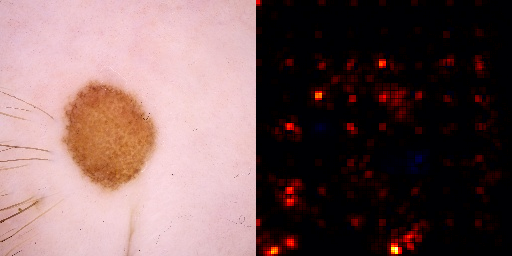

shape of A in gated attention: torch.Size([1, 2048, 1])


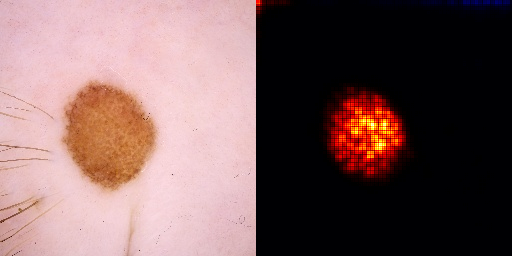

In [250]:
POSITIVE = False

if POSITIVE:
    x, path = next(positive_iterator)
    targets = [1] * x.shape[0]
else:
    x, path = next(negative_iterator)
    targets = [0] * x.shape[0]

for model, model_name in zip(models, model_names):
    # attention
    explanation = lrp_explainer(
        inputs=x,
        targets=targets,
        model=model,
        sum_channels=True,
        normalise=False
    )
    img = imgify(explanation[0], symmetric=True, cmap='coldnhot')
    new_img = stacked_img(path, img)
    # show the image
    display(new_img)
    


### Evaluate Avg Sensitivity

In [266]:

# input = torch.randn(2, 3, 32, 32, requires_grad=True)
# # Computes saliency maps for class 3.
# attribution = saliency.attribute(input, target=0)
# # define a perturbation function for the input
# lrp_explainer(x,  targets = [1.0] * x.shape[0], model=models[0], sum_channels=True, normalise=False)
from captum.attr import Saliency
saliency = Saliency(model)
saliency.attribute(x, target=0)
# x.requires_grad_(True)
for model, model_name in zip(models, model_names):
   # if isinstance(model, ResNetAtt):
   #     model = AttentionWrapper(model)
   # explanation = partial(lrp_explainer, model=model, sum_channels=True, normalise=False)
   saliency = Saliency(model)
   
   # sensitivity = sensitivity_max(lrp_explainer, x, model=model, sum_channels=True, normalise=False, targets = [1.0] * x.shape[0])

tensor([[[[3.8418e-04, 5.4175e-04, 1.5582e-03,  ..., 1.0063e-04,
           1.3796e-04, 4.1733e-05],
          [1.9660e-04, 1.9560e-03, 5.8908e-04,  ..., 1.3130e-04,
           1.5577e-04, 6.4804e-06],
          [1.4102e-03, 1.0121e-03, 6.8745e-04,  ..., 1.7564e-04,
           2.1556e-04, 1.0614e-04],
          ...,
          [1.0730e-04, 1.0703e-03, 6.7606e-04,  ..., 3.1480e-04,
           7.3325e-05, 1.8550e-04],
          [2.9624e-04, 1.1327e-03, 6.5731e-04,  ..., 1.8839e-04,
           2.4424e-04, 3.7852e-04],
          [7.3302e-05, 6.3488e-04, 8.7642e-04,  ..., 3.4037e-04,
           4.6623e-04, 4.5142e-04]],

         [[1.0441e-03, 6.9516e-04, 2.1028e-03,  ..., 5.3108e-05,
           9.9839e-05, 3.6117e-05],
          [3.4718e-04, 1.3302e-03, 6.0382e-05,  ..., 1.6752e-04,
           1.4277e-04, 5.5304e-05],
          [1.2216e-03, 9.6449e-05, 8.3254e-04,  ..., 1.4279e-04,
           6.0917e-05, 6.2921e-05],
          ...,
          [2.4273e-04, 9.2759e-04, 2.3290e-03,  ..., 1.2928

In [253]:
# # use the ResNet-specific canonizer
# canonizer = ResNetCanonizer()

# # create a composite, specifying the canonizers
# composite = EpsilonPlusFlat(canonizers=[canonizer])

# # target = torch.eye(2)[[img[1]]] * out[0, 1]
# target = torch.eye(2)[[1]]
# # https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

# # create the attributor, specifying model and composite
# with Gradient(model=model, composite=composite) as attributor:
#     # compute the model output and attribution
#     output, attribution = attributor(test_tensor, target)
    
# # from zennit.image import imgify
# # sum over the channels
# relevance = attribution.sum(1)

# # create an image of the visualize attribution
# # img = imgify(relevance, symmetric=True, cmap='coldnhot')
# # new_img = stacked_img(path, img)
# # show the image
# # display(new_img)

def lrp_explainer(
    inputs, targets, model, abs=False, normalise=False, sum_channels = False, *args, **kwargs
) -> np.array:
    print(inputs)
    print(targets)
    print(model)
    # inputs = x_batch
    # targets = y_batch
    # gc.collect()
    # torch.cuda.empty_cache()

    # Set model in evaluate mode.
    # model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
            .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 256),
                kwargs.get("img_size", 256),
            )
            .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = (
            torch.as_tensor(targets).long().to(kwargs.get("device", None))
        )  # inputs = inputs.reshape(-1, 3, 224, 224)

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    # use the ResNet-specific canonizer
    canonizer = ResNetCanonizer()

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    col1 = targets == 0
    col2 = targets == 1
    target = torch.vstack([col1, col2]).T.int()

    # # target = torch.eye(2)[[img[1]]] * out[0, 1]
    # target = torch.eye(2)[[1]]
    # https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(inputs, target)
        
    # from zennit.image import imgify
    # sum over the channels
    if sum_channels:
        relevance = attribution.sum(1)
    else:
        relevance = attribution

    explanation = relevance
    # (
    #     Saliency(model)
    #     .attribute(inputs, targets, abs=abs)
    #     .sum(axis=1)
    #     .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
    #     .cpu()
    #     .data
    # )

    # gc.collect()
    # torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()
    print(explanation.cpu())
    explanation = explanation.cpu().detach().numpy()
    return explanation

### Evaluate Infidelity

In [6]:
# x, y = next(iter(dataloader))

# metric_init = quantus.AvgSensitivity(
#     nr_samples=10,
#     lower_bound=0.1,
#     norm_numerator=quantus.norm_func.fro_norm,
#     norm_denominator=quantus.norm_func.fro_norm,
#     perturb_func=quantus.perturb_func.uniform_noise,
#     similarity_func=quantus.similarity_func.difference,
#     disable_warnings=True,
#     normalise=True,
#     abs=True,
# )

# metric_init(
#     model=model,
#     x_batch=x.numpy(),
#     y_batch=y.numpy(),
#     explain_func=lrp_explainer,
# )


/home/maciejpioro/Documents/studia/xai/xai_project/venv/lib/python3.10/site-packages/quantus/helpers/warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


[0.01905845822766423]

In [7]:
x.mean()

tensor(-0.3786)

In [8]:
metric_init = quantus.Infidelity(
    # nr_samples=10,
    # lower_bound=0.1,
    # norm_numerator=quantus.norm_func.fro_norm,
    # norm_denominator=quantus.norm_func.fro_norm,
    # perturb_func=quantus.perturb_func.uniform_noise,
    # similarity_func=quantus.similarity_func.difference,
    # disable_warnings=True,
    # normalise=True,
    abs=True,
    display_progressbar=True
)

metric_init(
    model=model,
    x_batch=x.numpy(),
    y_batch=y.numpy(),
    explain_func=lrp_explainer,
)

Warnings and information:
 (1) The Infidelity metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', perturbation function 'perturb_func',number of perturbed samples 'n_perturb_samples', the loss function 'loss_func' aggregation boolean 'aggregate'. Also, the current implementation only works for 3-dimensional (image) data. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Chih-Kuan, Yeh, et al. 'On the (In)fidelity and Sensitivity of Explanations'arXiv:1901.09392 (2019).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



Evaluating Infidelity:   0%|          | 0/1 [00:00<?, ?it/s]


ValueError: indices dimension doesn't match indexed_axes

In [ ]:
metric_init.get_params

{'abs': True,
 'normalise': False,
 'return_aggregate': False,
 'aggregate_func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 'normalise_func_kwargs': {},
 'disable_warnings': False,
 'display_progressbar': True,
 'a_axes': array([0, 1, 2]),
 'perturb_func': <function quantus.functions.perturb_func.baseline_replacement_by_indices(arr: <built-in function array>, indices: Tuple[slice, ...], indexed_axes: Sequence[int], perturb_baseline: Union[float, int, str, <built-in function array>], **kwargs) -> <built-in function array>>,
 'perturb_func_kwargs': {'perturb_baseline': 'black'},
 'loss_func': <function quantus.functions.loss_func.mse(a: <built-in function array>, b: <built-in function array>, **kwargs) -> float>,
 'perturb_patch_sizes': [4],
 'n_perturb_samples': 10,


In [ ]:
x, y = next(iter(dataloader))

quantus.evaluate(
    metrics = {
        "sensitivity": metric_init
    },
    model=model, 
    xai_methods={
        'lrp': lrp_explainer},
    x_batch=x,
    y_batch=y
)

ERROR IMG LOADED:  data/train/train/ISIC_9382494.jpg
ERROR IMG LOADED:  data/train/train/ISIC_2353030.jpg
ERROR IMG LOADED:  data/train/train/ISIC_1667108.jpg
ERROR IMG LOADED:  data/train/train/ISIC_6653225.jpg
ERROR IMG LOADED:  data/train/train/ISIC_0887530.jpg
ERROR IMG LOADED:  data/train/train/ISIC_3688362.jpg
ERROR IMG LOADED:  data/train/train/ISIC_0440291.jpg
ERROR IMG LOADED:  data/train/train/ISIC_0030653.jpg
ERROR IMG LOADED:  data/train/train/ISIC_7733258.jpg
ERROR IMG LOADED:  data/train/train/ISIC_2451803.jpg


TypeError: lrp_explainer() missing 2 required positional arguments: 'x_batch' and 'y_batch'

In [ ]:
# model(x)
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
# y.shape
# x.shape
# explanation.shape
# model(x)
# explanation.shape
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
# from captum.metrics import infidelity
# import torch
# # ImageClassifier takes a single input tensor of images Nx3x32x32,
# # and returns an Nx10 tensor of class probabilities.
# # net = ImageClassifier()
# # saliency = Saliency(net)
# # input = torch.randn(2, 3, 32, 32, requires_grad=True)
# # Computes saliency maps for class 3.
# # attribution = saliency.attribute(input, target=3)
# # define a perturbation function for the input
# explanation = lrp_explainer(x, y, model, abs=False, normalise=False, sum_channels=False)
# def perturb_fn(inputs):
#    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
#    return noise, inputs - noise
# # Computes infidelity score for saliency maps
# infid = infidelity(model, perturb_fn, x, torch.tensor(explanation))

RuntimeError: The size of tensor a (10) must match the size of tensor b (20) at non-singleton dimension 1

In [ ]:
# explanation.shape
# y.shape
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
import torch
net =  torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=10)

Using cache found in /home/maciejpioro/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
from captum.attr import Saliency
from captum.metrics import infidelity, sensitivity_max
import numpy as np
# net = ImageClassifier()
# net = model
saliency = Saliency(net)
input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Computes saliency maps for class 3.
attribution = saliency.attribute(input, target=0)
# define a perturbation function for the input
def perturb_fn(inputs):
   noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
   return noise, inputs - noise
# Computes infidelity score for saliency maps
infid = infidelity(net, perturb_fn, input, attribution, target=1)
# sens = sensitivity_max(net, input)

NameError: name 'net' is not defined

In [ ]:
infid

tensor([ 69.1644, 108.0205])

In [ ]:
net(input).shape

torch.Size([2, 10])

In [ ]:
!pip freeze

asttokens==2.2.0
backcall==0.2.0
black==22.12.0
captum==0.5.0
certifi==2022.9.24
charset-normalizer==2.1.1
click==8.1.3
contourpy==1.0.6
cycler==0.11.0
debugpy==1.6.4
decorator==5.1.1
efficientnet-pytorch==0.7.1
einops==0.6.0
entrypoints==0.4
executing==1.2.0
filelock==3.8.0
fonttools==4.38.0
huggingface-hub==0.11.1
idna==3.4
imageio==2.23.0
ipykernel==6.17.1
ipython==8.7.0
jedi==0.18.2
joblib==1.2.0
jupyter_client==7.4.7
jupyter_core==5.1.0
kiwisolver==1.4.4
matplotlib==3.6.2
matplotlib-inline==0.1.6
mypy-extensions==0.4.3
nest-asyncio==1.5.6
networkx==2.8.8
numpy==1.23.5
nvidia-cublas-cu11==11.10.3.66
nvidia-cuda-nvrtc-cu11==11.7.99
nvidia-cuda-runtime-cu11==11.7.99
nvidia-cudnn-cu11==8.5.0.96
opencv-python==4.6.0.66
packaging==21.3
pandas==1.5.2
parso==0.8.3
pathspec==0.10.3
pexpect==4.8.0
pickleshare==0.7.5
Pillow==9.3.0
platformdirs==2.5.4
prompt-toolkit==3.0.33
protobuf==3.19.6
psutil==5.9.4
ptyprocess==0.7.0
pure-eval==0.2.2
Pygments==2.13.0
pyparsing==3.0.9
python-dateutil==2.8